<a href="https://colab.research.google.com/github/98bao/Migros/blob/main/Project_last_Nicolak_foldpynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DMML2020 - Project
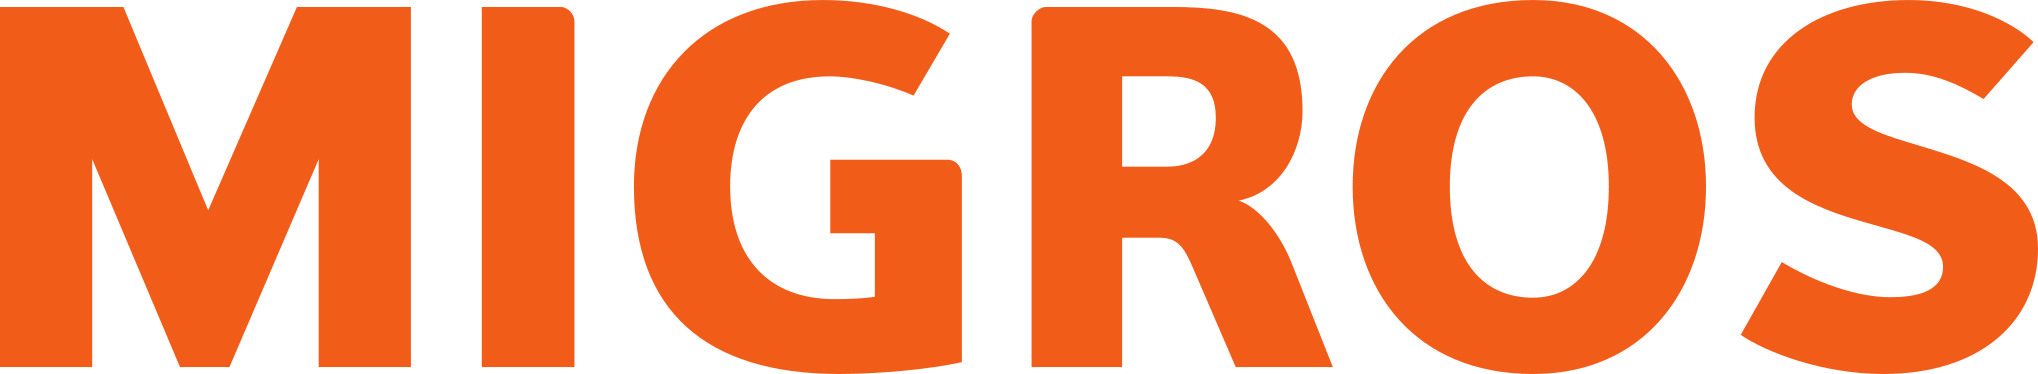
##Classification problem
In this project we analyze the data to know if a tweet is about a real disaster (target = 1) or not (target = 0).


In this first iteration we just fit the training data in the Logistic regression and observe the accuracy.

#Report 📋
  1) At first we submitted a simple logistic regression without data cleaning which gave us a satisfying accuracy of **0.805** on AICrowd
  
  2) We cleaned the text by deleting unecessary elements, then applied a logistic regression with cross validation (LRCV). Although the model built on the train data is pretty good, the accuracy on AICrowd got lower: **0.797**

  3) We used the Random Forest Classifier (RFC) and its model accuracy seemed very promising (0.97 for the train data) however, whilst submitting to AICrowd we got only a result of **0.77**. It seems like we are missing an important point as our accuracy keeps getting lower. Perhaps our model is overfitting the train data, thus we have to correct our parameters

#Importing useful tools 🧰

In [65]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [2]:
#clear output
%%capture 
# Install and update spaCy
!pip install -U spacy

!python -m spacy download en

In [66]:
import spacy
from spacy import displacy

In [67]:
import spacy
from spacy import displacy

In [5]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 14.8MB/s 


In [6]:
from textblob import TextBlob


In [7]:
#clear output
%%capture 

#Importing useful extensions
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

import string
from spellchecker import SpellChecker

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from gensim.parsing.preprocessing import remove_stopwords

In [8]:
import matplotlib.pyplot as plt


#Importing the project dataframes in the notebook 📚
In the following cells, we import some raw dataframes that we are going to use for the project

In [68]:
#Reading the dataframe to build our model
df_train = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/training_data.csv")
df_train.head(5)

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


In [69]:
#Reading dataframe which is going to be tested
df_test = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/test_data.csv")
df_test.head(6)

,id,keyword,location,text
0,9972,tsunami,NaN,Crptotech tsunami and banks.\n http://t.co/KHz...
1,9865,traumatised,"Portsmouth, UK",I'm that traumatised that I can't even spell p...
2,1937,burning%20buildings,NaN,@foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...
3,3560,desolate,NaN,Me watching Law &amp; Order (IB: @sauldale305)...
4,2731,crushed,bahstun/porta reeko,Papi absolutely crushed that ball
5,10020,twister,NaN,Brain twister let drop up telly structuring ca...


In [70]:
#Reading the sample submission
sample_submission = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/sample_submission.csv")

#Exploratory data analysis 🕵️

1.   Base rate
2.   List item



####1. Base rate
This indicate how often the most common value appears in the dataframe. We have to obtain an accuracy that is superior to the base rate to say that our classifier is well made.

In [ ]:
#Base rate of the train df
df_train['target'].value_counts() /len(df_train) 

#The base rate of this dataframe is 0.572

0    0.571936
1    0.428064
Name: target, dtype: float64

In [ ]:
#Are there null values ?
print(df_train.text.isnull().sum())
print(df_train.keyword.isnull().sum())

0
55


In [ ]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6471 non-null   int64 
 1   keyword   6416 non-null   object
 2   location  4330 non-null   object
 3   text      6471 non-null   object
 4   target    6471 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 252.9+ KB


#Building the tokenizer 🤖
In the following part, we create our tokenizer which will be used to analyze the text column

In [30]:
#Create Tokenizer

#Stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
#Punctuation
punctuations = string.punctuation

sp = spacy.load('en_core_web_sm')

#Tokenizer function
def spacy_tokenizer(sentence):
    mytokens = sp(sentence)

# Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]  
# Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
# Remove words with two letters or less
    mytokens = [ word for word in mytokens if len(word)>2 ]   
# Return preprocessed list of tokens
    return mytokens
#demo
review = df_train["text"].sample()
review.values[0]


/usr/local/lib/python3.6/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


'Hollywood movie about trapped miners released in Chile'

In [ ]:
#TF-IDF feature vector
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

#Logistic regression and pipeline

Our first iteration of the model: *No treatement of the dataframe*, just fitted in a logistic regression to see the result. We submitted this first try on AICrowd to check the accuracy of an uncleaned database.



In [ ]:
#Setting up the train test split

#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=100)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...,
                                 tokenizer=<function spacy_tokenizer at 0x7fb1ee75dae8>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_i

####Accuracy

In [ ]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.8906
CONFUSION MATRIX:
[[2852   82]
 [ 477 1698]]


In [ ]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.8091
CONFUSION MATRIX:
[[681  61]
 [183 353]]


####Using keywords only
This is a test to see if using only the keywords would give a good accuracy

In [ ]:
#Replace null value by an arbitrary string
df_train.keyword.fillna(value = 'nokeyword', inplace = True)

#Verify
df_train.keyword.isnull().sum()

0

In [ ]:
#Using keyword in the model
features = ['keyword', 'text']

X = df_train['keyword']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=100)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])



In [ ]:
#Fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...,
                                 tokenizer=<function spacy_tokenizer at 0x7f8d94447950>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_i

In [ ]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.7361
CONFUSION MATRIX:
[[2374  587]
 [ 779 1436]]


In [ ]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7174
CONFUSION MATRIX:
[[583 157]
 [209 346]]


#Data cleaning 🧼
To further improve the accuracy of our model, we cleaned the text column by removing unecessary elements such as URL, Tags and noise.

In [31]:
#Need to replace NaN values by blank spaces otherwise some funtions wont run  ----> is it right only on df_test ? 
df_test['text'] = df_test['text'].replace(np.nan, '')


In [32]:

#Clean duplicates
df_train =  df_train.drop_duplicates(subset=['text'], keep='first')

#replacing "%20" with space
df_train['keyword'] = df_train['keyword'].replace('%20', ' ', regex = True)
df_train['text'] = df_train['text'].replace('%20', ' ', regex = True)
df_test['keyword'] = df_test['keyword'].replace('%20', ' ', regex = True)
df_test['text'] = df_test['text'].replace('%20', ' ', regex = True)

#removing twitter tags
def remove_tags(text):
  text = re.sub(r'@\S+','',text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_tags(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_tags(x))

#removing hashtags
def remove_hash(text):
  text = re.sub('#','',text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_hash(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_hash(x))

#removing amp
def amp(text):
  text = re.sub('&amp;', '', text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: amp(x))
df_test['text'] = df_test['text'].apply(lambda x: amp(x))

#removing url
def remove_url(text):
  text = re.sub(r'http\S+', '', text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: remove_url(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_url(x))



In [33]:
#removing noises
def remove_noise(text):
  text = re.sub('RT ', '', text)
  return text
df_train['text'] = df_train['text'].apply(lambda x: remove_noise(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_noise(x))


In [34]:

# Remove other strange characters noise
def remove_noise_1(text):
  
  text = re.sub('&', '', text)
  text = re.sub('', '', text)
  text = re.sub('ûªs','',text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_noise_1(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_noise_1(x))

#Remove multiple spaces and spaces from Start and End 
def remove_multiple_spaces(text):
  text = re.sub(r"\s+"," ", text, flags = re.I)
  text = re.sub(r"^\s+", "", text)
  return text
df_train['text'] = df_train['text'].apply(lambda x: remove_multiple_spaces(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_multiple_spaces(x))

#Remove uppercase character
def remove_uppercase(text):
   text = text.lower()
   return text
df_train['text'] = df_train['text'].apply(lambda x: remove_uppercase(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_uppercase(x))



I did not use Following text cleaning methods (only above methods) and i obtained accuracy of 0.8177 with simple logreg.

- Removing all the numbers makes prediction worse (i have got worst result removing them using the same random_state set on train test split andd on logreg). Maybe we have to mantain dates and remove only  "strange" numbers? (if so HOOOOOW?) 
- 




In [ ]:
# Remove Stopwords
def remove_stopword(text):
  text= remove_stopwords(text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: remove_stopword(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_stopword(x))

#Remove uppercase character
def remove_uppercase(text):
   text = text.lower()
   return text
df_train['text'] = df_train['text'].apply(lambda x: remove_uppercase(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_uppercase(x))

## Remove single charachters
def remove_single_characters(text):
   text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
   return text
df_train['text'] = df_train['text'].apply(lambda x: remove_single_characters(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_single_characters(x))


In [ ]:
# remove digits
def remove_digits(text):
  text = re.sub(r"\d", "", text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_digits(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_digits(x))

#Remove multiple spaces and spaces from Start and End 
def remove_multiple_spaces(text):
  text = re.sub(r"\s+"," ", text, flags = re.I)
  text = re.sub(r"^\s+", "", text)
  return text
df_train['text'] = df_train['text'].apply(lambda x: remove_multiple_spaces(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_multiple_spaces(x))

# Remove single charachters
def remove_single_characters(text):
   text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
   return text
df_train['text'] = df_train['text'].apply(lambda x: remove_single_characters(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_single_characters(x))

#Remove uppercase character
def remove_uppercase(text):
   text = text.lower()
   return text
df_train['text'] = df_train['text'].apply(lambda x: remove_uppercase(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_uppercase(x))

# Remove other strange characters noise
def remove_noise_1(text):
  text = re.sub('û_', '',text)
  text = re.sub('û', '', text)
  text = re.sub('&', '', text)
  text = re.sub('', '', text)
  text = re.sub('ª', '', text)
  text = re.sub('ûªs', '',text)
  return text
df_train['text'] = df_train['text'].apply(lambda x: remove_noise_1(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_noise_1(x))


#removing punctuation
def remove_punct(text):
  text = "".join([char for char in text if char not in string.punctuation])
  text = re.sub(r"[0-9]+", "", text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_punct(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_punct(x))

In [ ]:
#Spellchecking the text (it takes too much time)
#df_train.text.apply(lambda txt: ''.join(TextBlob(txt).correct()))


In [ ]:
lalo ="il campione di; calcio,  9999999 non. ri!!spetta le re??gole!!!!!! ???????????"
remove_punct(lalo)

NameError: ignored

In [ ]:
#Convert dataframes to csv file to check if the rows of text looks good
df_train['text'].to_csv('df_train.csv')
df_test.to_csv('df_test.csv')


In [ ]:
# We begin by grouping text message by target 
df_train_grouped =df_train[['target','text']].groupby(by='target').agg(lambda x: ' '.join(x))
corpus = df_train_grouped['text']
print(corpus)
corpus0 = corpus[[0]]
corpus1 = corpus[[1]]
# Now we create a funcion in order to find the most common words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

target
0    black eye 9: a space battle occurred at star o...
1    reality training: train falls off elevated tra...
Name: text, dtype: object


In [ ]:
Whole_tweets_most_common_words = get_top_n_words(corpus, 100)
print(Whole_tweets_most_common_words)
df = pd.DataFrame(Whole_tweets_most_common_words, columns= ['Token', 'Frequency'])
Tweets_0_most_common_words = get_top_n_words(corpus0, 30)
Tweets_1_most_common_words = get_top_n_words(corpus1, 30)
print("Corpus 0 :", Tweets_0_most_common_words)
print("Corpus 1 :", Tweets_1_most_common_words)
df1 = pd.DataFrame(Tweets_1_most_common_words, columns= ['Token', 'Frequency'])
df0 = pd.DataFrame(Tweets_0_most_common_words, columns= ['Token', 'Frequency'])


[('the', 502), ('like', 284), ('it', 270), ('you', 206), ('in', 166), ('people', 156), ('don', 156), ('new', 154), ('news', 137), ('emergency', 127), ('video', 123), ('disaster', 113), ('my', 111), ('we', 109), ('re', 108), ('is', 108), ('to', 107), ('police', 106), ('and', 100), ('this', 100), ('burning', 99), ('man', 99), ('body', 99), ('got', 98), ('that', 96), ('day', 95), ('storm', 95), ('know', 95), ('can', 95), ('buildings', 93), ('time', 93), ('what', 90), ('going', 88), ('nuclear', 87), ('love', 86), ('there', 85), ('now', 85), ('crash', 84), ('fire', 83), ('california', 83), ('fires', 82), ('suicide', 81), ('world', 80), ('good', 80), ('today', 79), ('if', 79), ('all', 78), ('dead', 77), ('he', 75), ('accident', 73), ('bomb', 72), ('me', 71), ('how', 71), ('they', 71), ('life', 70), ('attack', 70), ('no', 69), ('car', 69), ('think', 68), ('of', 68), ('home', 67), ('on', 67), ('train', 67), ('let', 66), ('but', 66), ('death', 66), ('way', 66), ('killed', 66), ('years', 64), ('

In [ ]:
def barchart_most_frequent_words(data, title):
    plt.style.use('dark_background')
    token= data['Token']
    frequency = data['Frequency']
    plt.bar(token, frequency)
    plt.title(title)
    plt.xlabel('Most frequent Words')
    plt.ylabel('Frequency')
    return plt.show()

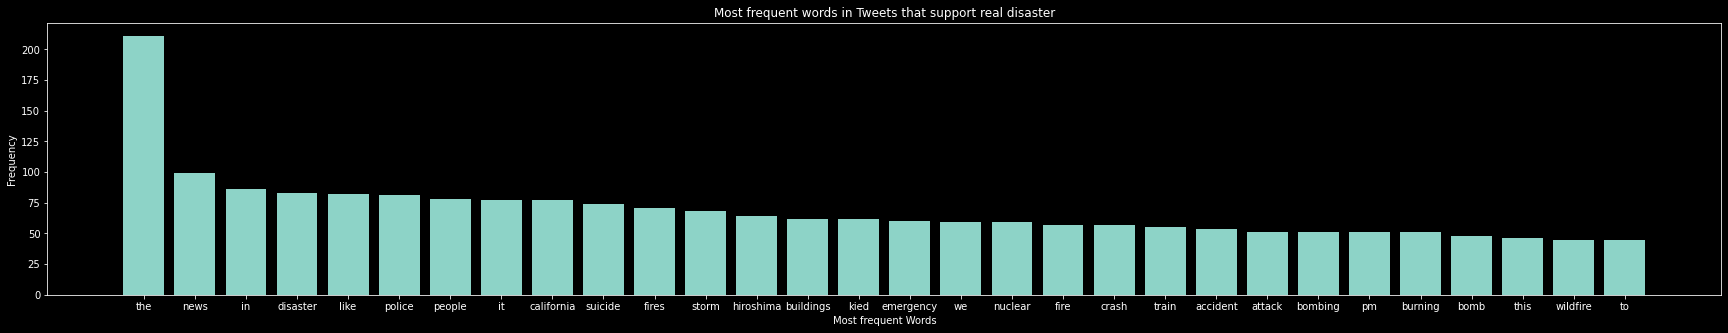

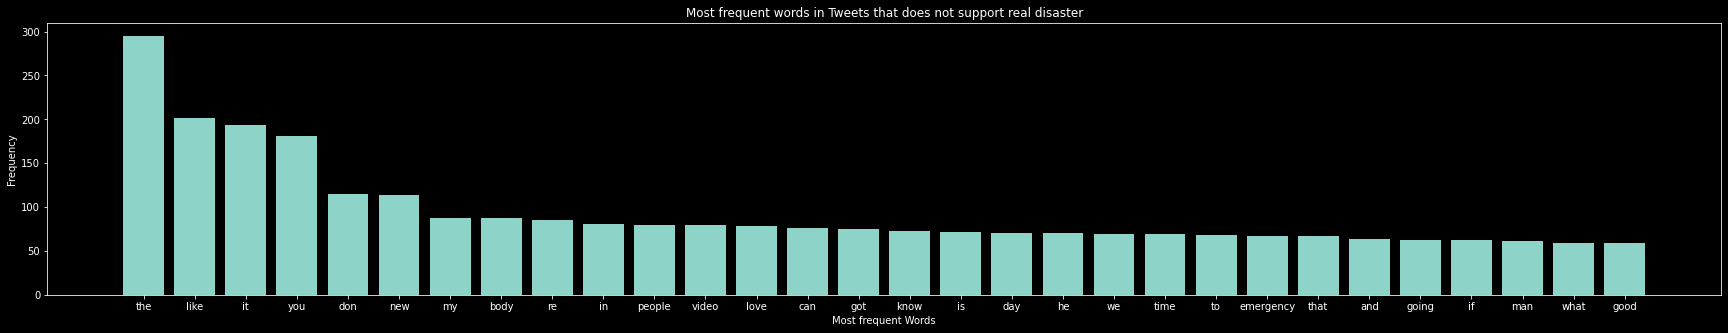

In [ ]:
plt.rcParams['figure.figsize']= (30, 5)
# Barchart Most important word 
barchart_most_frequent_words(df1, 'Most frequent words in Tweets that support real disaster')
barchart_most_frequent_words (df0, 'Most frequent words in Tweets that does not support real disaster')

#Logistic regression and pipeline after Data cleaning 

Our second iteration of the model: *treatement of the dataframe with text cleaning*, fitted in a logistic regression to see the result.



In [132]:
#Setting up the train test split
#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [133]:
#TF-IDF feature vector
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1, 1), min_df=1, max_df=1.0, analyzer='word')

In [145]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72, C=10.0)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

In [146]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...,
                                 tokenizer=<function spacy_tokenizer at 0x7f2ed3048ea0>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=10.0, class_weight=None, dual=False,
                                    fit_

In [143]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.9260
CONFUSION MATRIX:
[[2879   68]
 [ 315 1914]]


In [144]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7969
CONFUSION MATRIX:
[[639 115]
 [148 393]]


In [ ]:
target_test = pipe.predict(df_test['text'])
target_test =pd.DataFrame(target_test)
target_test

,0
0,0
1,0
2,1
3,0
4,0
...,...
1137,1
1138,1
1139,1
1140,0


In [ ]:
sample_submission.assign(target = target_test)
target_test.to_csv('submission_newparams.csv', index=False)


#Logistic Regression with  K-Fold cross-validation
We have seen that the accurancy result from the Logistic regression can present significat change based on the split of the train_ test data(from about 0.78 to 0.82). In fact the train_test split change every time we run the code.
For that reason we decided to use k-fold cross validation for the test train split. Using this method we can split...

In [101]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
folds= StratifiedKFold(n_splits=3)
X = df_train['text']
y = df_train['target']

In [98]:
# Setting up the train_test Split using StratifiedKfold 
folds= StratifiedKFold(n_splits=10)

metrics =[]

for  train_index, test_index in kf.split(df_train):
     X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
     tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(4, 3), min_df=1, max_df=1.0, analyzer='char')
     X_train_td = tfidf_vector.fit_transform(X_train)
     X_test_td = tfidf_vector.transform(X_test)
     LR = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72)
     LR.fit(X_train_td, y_train)
     y_pred_class = LR.predict(X_test_td)
     metric.append(accuracy_score(y_test, y_pred_class))
     metric = np.array(metric)
print(metric)

In [108]:
metric = np.array(metric)
print(metric)

[0.79415855 0.80945758 0.76634214 0.79972184 0.8038943  0.81919332
 0.78859527 0.79694019 0.81502086 0.79415855]


In [104]:
print('Mean accurancy:', np.mean(metric, axis=0))
print('Std for accuracy:', np.std(metric, axis=0))

Mean accurancy: 0.7987482614742698
Std for accuracy: 0.01422517804016908


## Cross validation Model selection  

In [88]:
# define features 
X = df_train['text']
y = df_train['target']
# Define vectorizer 
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1, 1), min_df=1, max_df=1.0, analyzer='word')
X_tdf_vec = tfidf_vector.fit_transform(X)

In [96]:
# 10-fold cross-validation with the logistic regression
scores =cross_val_score(LogisticRegression(), X_tdf_vec, y, cv=10, scoring='accuracy')
scores = np.array(scores)
print('Score_mean:', np.mean(scores))
print('Score_sdt:', np.std(scores))

Score_mean: 0.7973996794321369
Score_sdt: 0.019073823555234484


In [101]:
#10- fold cross-validation with the random forrest classifier
scores_lrcv =cross_val_score(RandomForestClassifier(), X_tdf_vec, y, cv=10, scoring='accuracy')
scores_lrcv = np.array(scores_lrcv)
print('Score_mean:', np.mean(scores_lrcv))
print('Score_sdt:', np.std(scores_lrcv))

Score_mean: 0.785037304176923
Score_sdt: 0.0205436967113259


In [116]:
from sklearn.neighbors import KNeighborsClassifier
# 10-fold cross-vaidation KNN model k=15
knn = KNeighborsClassifier(n_neighbors=15)
scores_knn =cross_val_score(knn, X_tdf_vec, y, cv=10, scoring='accuracy')
scores_knn =np.array(scores_knn)
print('Score_mean:', np.mean(scores_knn))
print('Score_std:',  np.std(scores_knn))

Score_mean: 0.7842668918274276
Score_std: 0.016112445077314175


In [108]:
# search for an optimal value of K for KNN

# range of k we want to try
k_range = range(1, 31)
# empty list to store scores
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores= cross_val_score(knn, X_tdf_vec, y, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())


print(k_scores)

[0.7366685271051577, 0.7462483542274887, 0.7601560860190432, 0.7657204667315435, 0.77190570916099, 0.77051133436373, 0.7757651649588796, 0.7736018089186558, 0.7811764172725019, 0.7770040261797088, 0.7824128933157783, 0.7799394641937145, 0.7816393802354646, 0.7819487377640393, 0.7842668918274276, 0.7766941916156238, 0.7787029881504379, 0.7777753926002251, 0.7785493827160495, 0.7746844410097888, 0.777776108153491, 0.7754577155723472, 0.7763869807468468, 0.773140754097735, 0.7793228957963632, 0.7725210849695652, 0.7762314671704162, 0.769430371896884, 0.7722126815120118, 0.7688128494285115]


Text(0, 0.5, 'Cross-validated accuracy')

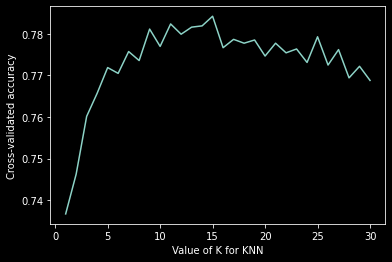

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot how accuracy changes as we vary k
plt.style.use('dark_background')
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

#Logistic regression improvement 

In order to achieve a better result we proceed as follow: 
- Exploration of Logistic regression parameters
- Optimize TF-IDF parameters
- optimize logistic regression parameters with gridSearchCV 
- Try some dimensionality reduction in order to improve accurancy and speed (Standardization and PCA)


### Exploring Logistic Regression Parameters scores using cross-validation

In [ ]:
LR = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72)

In [159]:
# search for an optimal solver 

# Type of solver we want to try 
solvers= ['lbfgs', 'saga', 'sag', 'liblinear', 'newton-cg'] 
# empty list to store scores
solver_scores = []

# 1. we will loop through type of solver 
for k in solvers:
    # 2. run logistic Regression  with k solver
    LR = LogisticRegression(solver=k, max_iter=1000, random_state=72)
    # 3. obtain cross_val_score for Logistic Regression  with k Solver
    scores= cross_val_score(LR, X_tdf_vec, y, cv=10, scoring='accuracy')
    # 4. append mean of scores for k solver to solver_scores list
    solver_scores.append(scores.mean())


print(solver_scores)

[0.7973996794321369, 0.7975542389375465, 0.7975542389375465, 0.7977087984429561, 0.7975542389375465]


Text(0, 0.5, 'Score')

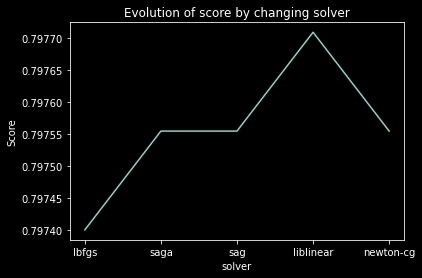

In [160]:
plt.style.use('dark_background')
plt.title('Evolution of score by changing solver')
plt.plot(solvers, solver_scores)
plt.xlabel('solver')
plt.ylabel('Score')

In [161]:
#search for optimal C parameter 

 

C_param = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]
C_score= []
# 1. we will loop through reasonable values of C
for k in C_param:
    # 2. run LogisticRegression  with value of C=k
    LR = LogisticRegression(solver='saga', max_iter=1000, random_state=72, C=k)
    # 3. obtain cross_val_score for LogisticRegression with value of C=k 
    scores_C= cross_val_score(LR, X_tdf_vec, y, cv=10, scoring='accuracy')
    # 4. append mean of scores for C=k to C_score list
    C_score.append(scores_C.mean())


print(max_C_score)

[0.7975542389375465, 0.799409430037972, 0.7991003110271528, 0.7990995954738872, 0.7983265594290839, 0.7992546320148073, 0.798327513500105, 0.7967828725170303, 0.7960105520254928, 0.7950831949930353, 0.7943108745014978, 0.7932294349991414, 0.7924568759898488, 0.7919931974736201, 0.791220399946572, 0.7910656019234071, 0.7909108039002424, 0.7907562443948327, 0.7898288873623753, 0.7893654473639018]


Text(0, 0.5, 'Score')

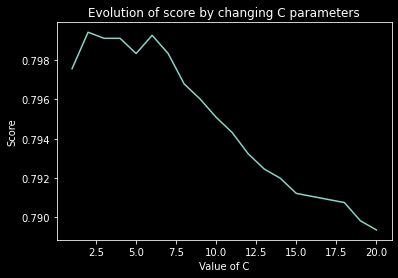

In [162]:
plt.style.use('dark_background')
plt.title('Evolution of score by changing C parameters')
plt.plot(C_param, C_score)
plt.xlabel('Value of C')
plt.ylabel('Score')

In [164]:
#search for optimal max_iter
# range of k we want to try
 
# empty list to store scores
max_iter = [100, 200, 500, 1000, 2000]
max_iter_score= []
# 1. we will loop through reasonable values of max_iter
for k in max_iter:
    # 2. run LogisticRegression with max_iter=k
    LR = LogisticRegression(solver='saga', max_iter=k, random_state=72, C=k)
    # 3. obtain cross_val_score for LogisticRegression with max_iter= k
    scores_iter= cross_val_score(LR, X_tdf_vec, y, cv=10, scoring='accuracy')
    # 4. append mean of scores for max_iter=k
    max_iter_score.append(scores_iter.mean())


print(max_iter_score)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

[0.7834926631938481, 0.7814833896235236, 0.781482912588013, 0.7804012345679012, 0.7788558780315606]


Text(0, 0.5, 'Score')

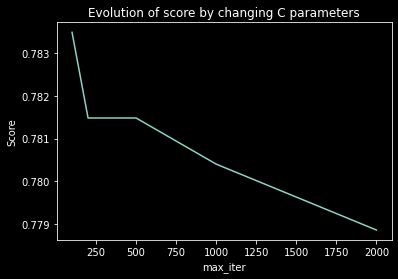

In [166]:
plt.style.use('dark_background')
plt.title('Evolution of score by changing C parameters')
plt.plot(max_iter, max_iter_score)
plt.xlabel('max_iter')
plt.ylabel('Score')

#Optimize the parameters of the TfidfVectorizer

In these chapter we are going to see if there are TF-IDF parameters who works better for our analysis.

In [ ]:
# Evaluate the model
def evaluate(true, pred):
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    f1 = f1_score(true, pred)
    print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

In [ ]:
# Create list of configs
def configs():

    models = list()
    
    # Define config lists
    ngram_range = [(1,1), (1,2), (1, 3), (2, 2), (2, 3), (3, 3), (3, 4)]
    min_df = [1]
    max_df = [1.0]
    analyzer=['word', 'char']
    
    # Create config instances
    for n in ngram_range:
        for i in min_df:
            for j in max_df:
              for a in analyzer:
                    cfg = [n, i, j, a]
                    models.append(cfg)
    return models

configs = configs()

In [ ]:
# Define list for result
result = []

for config in configs:

    # Redefine vectorizer
    tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, 
                                   ngram_range=config[0],
                                   min_df=config[1], max_df=config[2], analyzer=config[3])

    # Define classifier
    LR = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72)

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

    # Fit model on training set
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Print accuracy on test set
    print("CONFIG: ", config)
    evaluate(y_test, y_pred)
    print("-----------------------")

    # Append to result
    result.append([config, accuracy_score(y_test, y_pred)])

CONFIG:  [(1, 1), 1, 1.0, 'word']
CONFUSION MATRIX:
[[676  76]
 [161 365]]
ACCURACY SCORE:
0.8146
CLASSIFICATION REPORT:
	Precision: 0.8277
	Recall: 0.6939
	F1_Score: 0.7549
-----------------------
CONFIG:  [(1, 1), 1, 1.0, 'char']
CONFUSION MATRIX:
[[583 169]
 [249 277]]
ACCURACY SCORE:
0.6729
CLASSIFICATION REPORT:
	Precision: 0.6211
	Recall: 0.5266
	F1_Score: 0.5700
-----------------------
CONFIG:  [(1, 2), 1, 1.0, 'word']
CONFUSION MATRIX:
[[669  83]
 [165 361]]
ACCURACY SCORE:
0.8059
CLASSIFICATION REPORT:
	Precision: 0.8131
	Recall: 0.6863
	F1_Score: 0.7443
-----------------------
CONFIG:  [(1, 2), 1, 1.0, 'char']
CONFUSION MATRIX:
[[626 126]
 [198 328]]
ACCURACY SCORE:
0.7465
CLASSIFICATION REPORT:
	Precision: 0.7225
	Recall: 0.6236
	F1_Score: 0.6694
-----------------------
CONFIG:  [(1, 3), 1, 1.0, 'word']
CONFUSION MATRIX:
[[673  79]
 [168 358]]
ACCURACY SCORE:
0.8067
CLASSIFICATION REPORT:
	Precision: 0.8192
	Recall: 0.6806
	F1_Score: 0.7435
-----------------------
CONFIG:  [

### From this analysis we find out that there is some parameters that works better then the default ones specifically:
- ngram_range: (3, 4)
- min_df[1]
- max_df[1.0]
- Analyzer: 'char'


Improvement in test accurancy score from 0.7989 to 0.8099

In [ ]:
# Improved TF-IDF tokenizer
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')

###Optimize logistic regression parameters with gridSearchCV 
The above logistic regression was run with the default parameters.In this chapter we are trying to improve the accurancy by tuning the hyperparameters using the "GridSearch" method. 


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define vectorizer - use above cleaning function
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')

# Fit and transform X_train and X_test
X_train_vec = tfidf_vector.fit_transform(X_train)
X_test_vec = tfidf_vector.transform(X_test)
X_test_vec_s = tfidf_vector.transform(df_test['text'])
print(X_train_vec.shape)
print(X_test_vec.shape)
print(X_test_vec_s.shape)
X_train_vec

(2, 12)
(2, 12)
(1142, 12)


<2x12 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [ ]:
# Gridsearch Logistic regression
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model,  datasets

parameters = dict({'solver': ['lbfgs', 'saga'], 'C':[1, 10]})
LR = LogisticRegression(max_iter=1000, random_state=72)

clf = GridSearchCV(
    LR, parameters, scoring='accuracy'
    )
best_clf = clf.fit(X_train_vec, y_train)

In [ ]:
best_clf

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=72, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10], 'solver': ['lbfgs', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
y_pred_test_vec = best_clf.predict(X_test_vec)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test_vec):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test_vec)}")

TEST ACCURACY SCORE:
0.8114
CONFUSION MATRIX:
[[684  68]
 [173 353]]


In [ ]:
df_test['text'].shape

(1142,)

In [ ]:

tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')
X_test_vec_s = tfidf_vector.fit_transform(df_test['text'])
print(X_test_vec_s.shape)
print(X_test_vec.shape)

(1142, 29145)
(1278, 59155)


In [ ]:
y_pred_test_vec = best_clf.predict(X_test_vec_s)
y_pred_test_vec

array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
target_test = best_clf.predict(X_test_vec_s)
target_test =pd.DataFrame(target_test)
target_test

,0
0,0
1,0
2,1
3,0
4,0
...,...
1137,1
1138,1
1139,1
1140,0


In [ ]:
sample_submission.assign(target = target_test)
target_test.to_csv('submission_gridsearch.csv', index=False)


### Dimensionality reduction in order to improve accurancy and speed (Standardization and PCA)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import time

In [ ]:
# Define vectorizer - use above cleaning function
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')

In [ ]:
# Vectorize the text

from sklearn.feature_extraction.text import TfidfVectorizer

# Define vectorizer - use above cleaning function
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')

# Fit and transform X_train and X_test
X_train_vec = tfidf_vector.fit_transform(X_train).toarray()
X_test_vec = tfidf_vector.fit_transform(X_test).toarray()
print(X_train_vec.shape)
print(X_train_vec)
print(X_test_vec.shape)


(5109, 59028)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1278, 30376)


###PCA

In [ ]:
# Define Scaler
scaler = StandardScaler()

# Define PCA
pca = PCA(n_components=2000)

# Example on X_train_vec
X_train_vec_pca = pca.fit_transform(X_train_vec)

In [ ]:
print('Shape after PCA: ', X_train_vec_pca)
print('Number of components:', pca.n_components_)
print('Explained variance ratio: ', sum(pca.explained_variance_ratio_))

Shape after PCA:  PCA(copy=True, iterated_power='auto', n_components=5000, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
Number of components: 5000
Explained variance ratio:  1.0000000000000007


###Logistic regression 
- with PCA and standardization


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time

In [ ]:
# With PCA

# Define Model
pipe = Pipeline([
                 ('pca', pca),
                 ('logistic reg', LR),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

Time:  477.4866
Train Accuracy:  0.8655


ValueError: ignored

In [ ]:
print(X_test_vec.shape)
print(y_test.shape)

(1278, 30376)
(1278,)


In [ ]:
print(X_train_vec.shape)
print(y_train.shape)

(5109, 59028)
(5109,)


In [ ]:
# Define Scaler
scaler = StandardScaler()

# Define PCA
pca = PCA(n_components=5000)

# Example on X_train_vec
X_train_vec_pca = pca.fit_transform(X_train_vec)
print('Shape after PCA: ', X_train_vec_pca.shape)
print('Number of components: ', pca.n_components_)
print('Explained variance ratio: ', sum(pca.explained_variance_ratio_))

NameError: ignored

In [ ]:
# With Standardization
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time
 # Define classifier
LR = LogisticRegression(solver="lbfgs", max_iter=2000, random_state=72)
# Define Model
pipe = Pipeline([('scaler', scaler),
                 ('logistic reg', LogisticRegression())
                 ])

# Fit model
pipe.fit(X_train_vec, y_train)
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train Accuracy:  0.9979
Test Accuracy:  0.7398


In [ ]:
# With PCA and standardization
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time

# Define Model
pipe = Pipeline([
                 ('scaler', scaler),
                 ('pca', pca),
                 ('logistic reg', LR),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

NameError: ignored

#Using different classifiers 👨‍💻

We tried different classifier to know which one could predict the best our model

##Logistic regression with cross validation

In [167]:
#Setting up the train test split

#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y )

In [168]:
#Logistic regressin cross validation
from sklearn.linear_model import LogisticRegressionCV
LRCV = LRCV = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000, random_state=72)
#Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LRCV)])



In [169]:
#Fit
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                 tokenizer=<function spacy_tokenizer at 0x7f2ed3048ea0>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv=5,
                                      dual=Fal

In [170]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.9449
CONFUSION MATRIX:
[[2906   54]
 [ 231 1985]]


In [171]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7776
CONFUSION MATRIX:
[[629 112]
 [176 378]]


In [ ]:
target_test = pipe.predict(df_test['text'])
target_test

array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
sample_submission.target = target_test
sample_submission.to_csv('submission-12.csv', index=False)

##Random forest classifier 🌳🌳🌳
According to the documentation, the RFC looks like the most fitting classifier for our case. Thus we allocated a lot of ressources to improve its accuracy: in the section below there is a take on parameters tuning for RFC.

In [99]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Setting up the train test split

#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Define classifier
RFC = RandomForestClassifier(n_estimators = 16,max_depth = 60,random_state =42)
#Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', RFC)])

In [ ]:
#Fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(3, 4), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=60, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,


In [ ]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.9541
CONFUSION MATRIX:
[[2792    7]
 [ 211 1742]]


In [ ]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7593
CONFUSION MATRIX:
[[628  90]
 [196 274]]


In [ ]:
target_test = pipe.predict(df_test['text'])
target_test

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
sample_submission.target = target_test
sample_submission.to_csv('submission-13.csv', index=False)

####Plot different values of parameters to find which one is optimal
####1. n_estimator

In [ ]:
#packages needed for graphs
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

In [ ]:
#Create array of values for n_estimators
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

#Build function to test value of array in the model
train_results = []
test_results = []
for estimator in n_estimators:
   RFC = RandomForestClassifier(n_estimators=estimator, n_jobs=-1) 
   pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', RFC)])
   pipe.fit(X_train, y_train)
   #Training data curve
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)


NameError: ignored

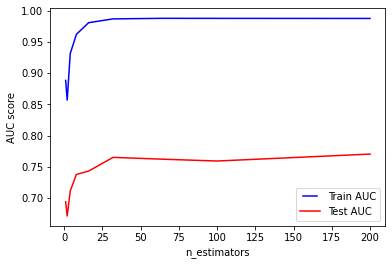

In [ ]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()
#We can see below a maximum for is between [25;50]

####2. max_depth

In [ ]:
#Tune max_depths parameters, analyze value between 1 and 100
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
#Creating a function
for max_depth in max_depths:
   RFC = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   
   pipe.fit(X_train, y_train)
   
   #Train data curve
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

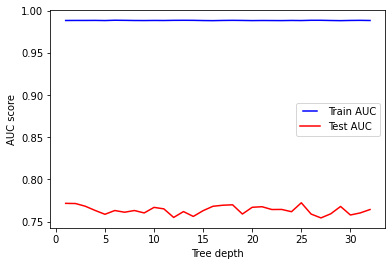

In [ ]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

####3. min_samples_split

In [ ]:
#Want to know what values between 10% or 100% of the samples is needed
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
#the function
for min_samples_split in min_samples_splits:
   RFC = RandomForestClassifier(min_samples_split=min_samples_split)
   #Train data curve
   pipe.fit(X_train, y_train)
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [ ]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

####4. max_features

In [ ]:
#nb of features to consider when looking for the best split
max_features = list(range(1,df_train.shape[1]))
train_results = []
test_results = []
#the function
for max_feature in max_features:
   RFC = RandomForestClassifier(max_features=max_feature)   
   pipe.fit(x_train, y_train)
   #Train data curve
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [ ]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r, label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

##Submission 👀
This is the code that we use to create the submission. To use it, we can just copy/paste it below the classifier of our choice and rename the .csv file.

In [ ]:
target_test = pipe.predict(df_test['text'])
target_test

In [ ]:
sample_submission.assign(target = target_test)
sample_submission.to_csv('submission-n.csv', index=False)